In [ ]:
#IMPORTS
import os
import cv2
from PIL import Image
import skimage.io as io
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.utils import to_categorical
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Image Preprocessing

Our first task is to split the combined images into 5 parts containing single letters. We apply image preprocessing after the split as the function parameters which we use can be different for different parts of the same image depending on the noise concentration or the contrast or the pixel intensities of that part.

In [ ]:
def split(image):
    # Get the dimensions of the image
    width, height = image.size

    # Calculate the width and height of each part
    part_width = width // 5
    part_height = height

    image_parts = []  #image_parts list which will contain the final parts after the split

    # Divide the image into parts and append to image_parts list

    for i in range(5):
        # Calculate the coordinates for cropping each part
        left = i * part_width
        upper = 0
        right = left + part_width
        lower = part_height

        # Crop the part from the image
        part = image.crop((left, upper, right, lower))

        # Append the part to the list
        image_parts.append(part)

    return image_parts

The following cell needs to be executed only once to create the samples_split folder which will contain the 5000 individual character images after the split.

On observing the image name contains the letters in the image in order.
So, after splitting we are saving the part names in the format -

[ letter ][ image_name ].png


In [ ]:
# images_folder = "/content/drive/MyDrive/JPMC_CaseStudy/samples1000"
# output_folder = "/content/drive/MyDrive/JPMC_CaseStudy/samples_split"

# # Preprocess each image and save in new directory
# for image_name in os.listdir(images_folder):
#     # Construct the full path to the image
#     image_path = os.path.join(images_folder, image_name)
#     image = Image.open(image_path)
#     image_parts = split(image)

#     for i,part in enumerate(image_parts):
#       part_name = os.path.basename(image_path)
#       part_name = part_name[i]+part_name
#       output_path = os.path.join(output_folder,part_name)
#       part.save(output_path)

Here we start defining the various image preprocessing functions that we have tried and tested to remove the noise and make the character more clear to improve our dataset.

We are passing image object as the parameter in our functions and have to convert it to a numpy array to apply the preprocessing technique and then convert it back into an image object before returning it.

In [ ]:
def grayscale(image):
    # Convert the image to grayscale: Reduces dimensionality and removes color
    grayscale_image = image.convert('L')
    return grayscale_image

MORPHOLOGICAL OPERATIONS

In [ ]:
def erode(image):
    # Convert image into NumPy array
    image_array = np.array(image)
    # Define the kernel for erosion
    kernel = np.ones((3, 3), np.uint8)
    # Perform image erosion
    eroded_image = cv2.erode(image_array, kernel, iterations=3)
    # Convert the NumPy array back to image object
    eroded_image = Image.fromarray(eroded_image)
    return eroded_image

In [ ]:
# DILATION : Increases the size of object. Fills holes in the object if any.
def dilate(image):
    image_array = np.array(image)
    # Define the kernel for erosion
    kernel = np.ones((3, 3), np.uint8)
    # Perform image dilation
    dilated_image = cv2.dilate(image_array, kernel, iterations=2)
    dilated_image = Image.fromarray(dilated_image)
    return dilated_image

In [ ]:
def opening(image):
    image_array = np.array(image)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(image_array, cv2.MORPH_OPEN, kernel, iterations=2)
    opened = Image.fromarray(opening)
    return opened

Various filters we tried out to remove the noise.

In [ ]:
def gaussian_blur(image):
    image_array = np.array(image)
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image_array, (11,11), 0)
    blurred_image = Image.fromarray(blurred_image)
    return blurred_image

In [ ]:
def median_filter(image):
    image_array = np.array(image)
    # Apply median filtering
    filtered_image = cv2.medianBlur(image_array, 9)
    filtered_image = Image.fromarray(filtered_image)
    return filtered_image

In [ ]:
def bilateral_filter(image):
    image_array = np.array(image)
    filtered_image = cv2.bilateralFilter(image_array, 9, 75, 75)
    filtered_image = Image.fromarray(filtered_image)
    return filtered_image

Different thresholds we tested to make a binary image and try to differentiate between noise and letter to make the letter more clear.

In [ ]:
def threshold(image):
    image_array = np.array(image)
    # Apply binary thresholding
    _, thresholded_image = cv2.threshold(image_array, 200, 255, cv2.THRESH_BINARY)
    thresholded_image = Image.fromarray(thresholded_image)
    return thresholded_image

In [ ]:
def adaptive_threshold(image):
    image_array = np.array(image)
    thresholded_image = cv2.adaptiveThreshold(image_array, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
    thresholded_image = Image.fromarray(thresholded_image)
    return thresholded_image

In [ ]:
def otsu_threshold(image):
    image_array = np.array(image)
    _, otsu_thresholded_image = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_thresholded_image = Image.fromarray(otsu_thresholded_image)
    return otsu_thresholded_image

Other preprocessing techniques we tested to improve the quality of our dataset.

In [ ]:
def denoise(image):
    image_array = np.array(image)
    # Apply fast NlMeans Denoising
    denoised_array = cv2.fastNlMeansDenoising(image_array, None, 10, 10, 7)
    denoised_image = Image.fromarray(denoised_array)
    return denoised_image

In [ ]:
def histogram_equalization(image):
    image_array = np.array(image)
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(image_array)
    equalized_image = Image.fromarray(equalized_image)
    return equalized_image

In [ ]:
def resize(image):
    image_array = np.array(image)
    # Apply histogram equalization
    resized_array = cv2.resize(image_array, (64, 128), interpolation=cv2.INTER_AREA)
    resized_image = Image.fromarray(resized_array)
    return resized_image

In [ ]:
def deskew(image):
    # Convert image to grayscale
    image_gray = image
    image_array = np.array(image_gray)
    # Apply thresholding to create binary image
    _, thresholded_image = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Sort contours by their area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    # Deskew each contour
    deskewed_images = []
    for contour in contours:
        # Find the minimum area rectangle enclosing the contour
        rect = cv2.minAreaRect(contour)
        # Calculate the angle of rotation
        angle = rect[2]
        # Rotate the image to deskew it
        rotated_image = Image.fromarray(image_array)
        rotated_image = rotated_image.rotate(-angle)
        deskewed_images.append(np.array(rotated_image))
    return deskewed_images

Here we have implemented our final preprocessing function after trying out many many combinations. We found that this preprocessing pipeline gives the best accuracy by maintaining the quality of the character and also removing majority of the noise.

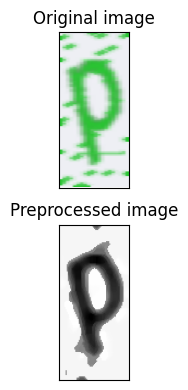

In [ ]:
def preprocess(img):
    img = resize(img)
    img = grayscale(img)
    img = histogram_equalization(img)
    img = dilate(img)
    img = denoise(img)
    img = median_filter(img)
    return img

image_path = "/content/drive/MyDrive/JPMC_CaseStudy/samples_split/pfaqep.png"   # Sample image
image = Image.open(image_path)
preprocessed_image = preprocess(image)

# Plot the original and the binary image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1, 4))
ax1.imshow(image, 'gray', aspect='auto')
ax1.set_title('Original image')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(preprocessed_image, 'gray', aspect='auto')
ax2.set_title('Preprocessed image')
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()

#MACHINE LEARNING

Now, we begin the Machine Learning part.

We have created functions to extract features, load our images and then prepare a features dataset for all the images.

In [ ]:
def extract_features(image):
    # Extract HOG features
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
    return features

In [ ]:
def load_images(folder_path):
    images = []
    labels = []
    number = [0]*26
    for part_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, part_name)
        image = Image.open(image_path)
        part_name = os.path.basename(image_path)
        number[ord(part_name[0])-ord('a')]+=1
        image = preprocess(image)
        images.append(image)

        labels.append(part_name[0])  # Part name format is [label][part_name].png
    return images, labels, number

In [ ]:
def prepare_data(images, labels):
    features = []

    for image in images:
        features.append(extract_features(image))

    X = np.array(features,dtype=object)
    y = np.array(labels)

    return X, y

In [ ]:
# Load and prepare the data
folder_path = "/content/drive/MyDrive/JPMC_CaseStudy/samples_split"

images, labels, number = load_images(folder_path)
X, y = prepare_data(images, labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

In [ ]:
print(number)

[190, 181, 190, 170, 177, 180, 168, 160, 170, 190, 167, 189, 194, 185, 176, 173, 168, 163, 195, 168, 178, 166, 174, 190, 186, 199]


<Axes: ylabel='count'>

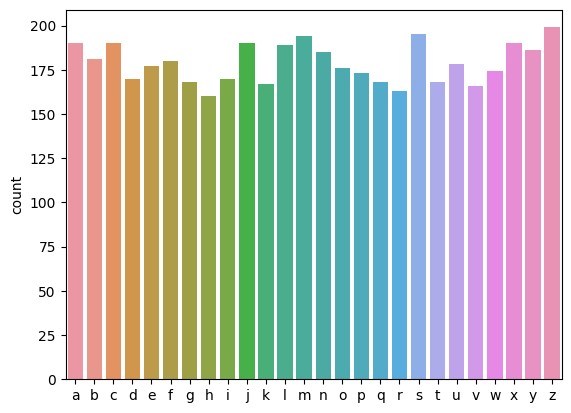

In [ ]:
class_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
sns.countplot(x=labels, order=class_labels)

Now we implement basic forms of the three specified classifiers - Logistic Regression, Support Vector Machine, Random Forest.

In [ ]:
# Create and train the Logistic Regression classifier
lrclf = LogisticRegression()
lrclf.fit(X_train, y_train)
y_pred = lrclf.predict(X_test)

# Evaluate the Logistic Regression classifier
lraccuracy = lrclf.score(X_test, y_test)
print("LR Accuracy:", 100*lraccuracy)
precision = precision_score(y_test, y_pred, average='micro')
print("LR Precision:", precision)
recall = recall_score(y_test, y_pred, average='micro')
print("LR Recall:", recall)
f1 = f1_score(y_test, y_pred, average='micro')
print("LR F1 score:", f1)


# Create and train the SVM classifier
svmclf = SVC(kernel='linear')
svmclf.fit(X_train, y_train)
y_pred = svmclf.predict(X_test)
# Evaluate the SVM classifier
svmaccuracy = svmclf.score(X_test, y_test)
print("SVM Accuracy:", 100*svmaccuracy)
precision = precision_score(y_test, y_pred, average='micro')
print("SVM Precision:", precision)
recall = recall_score(y_test, y_pred, average='micro')
print("SVM Recall:", recall)
f1 = f1_score(y_test, y_pred, average='micro')
print("SVM F1 score:", f1)

# Create and train the Random Forest classifier
rfclf = RandomForestClassifier(n_estimators=100)
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)
# Evaluate the Random Forest classifier
rfaccuracy = rfclf.score(X_test, y_test)
print("RF Accuracy:", 100*rfaccuracy)
precision = precision_score(y_test, y_pred, average='micro')
print("RF Precision:", precision)
recall = recall_score(y_test, y_pred, average='micro')
print("RF Recall:", recall)
f1 = f1_score(y_test, y_pred, average='micro')
print("RF F1 score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy: 74.6236559139785
LR Precision: 0.7462365591397849
LR Recall: 0.7462365591397849
LR F1 score: 0.7462365591397849
SVM Accuracy: 77.52688172043011
SVM Precision: 0.7752688172043011
SVM Recall: 0.7752688172043011
SVM F1 score: 0.7752688172043011
RF Accuracy: 72.90322580645162
RF Precision: 0.7290322580645161
RF Recall: 0.7290322580645161
RF F1 score: 0.7290322580645161


As we find that SVM is the best classifier among the three. We now implement GridSearchCV to find the best hyperparameter combination to maximise accuracy.

In [ ]:
# Create an SVM classifier
svm_classifier = svm.SVC()

# Define the hyperparameters to tune and their possible values
param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.5, 1.0]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = grid_search.best_params_

# Train the SVM with the best hyperparameters
best_svm = svm.SVC(**best_params)
best_svm.fit(X_train, y_train)

accuracy = best_svm.score(X_test, y_test)
print(accuracy)

In [ ]:
svmclf = SVC(kernel='poly', C=10, degree=2, coef0=0.0)
svmclf.fit(X_train, y_train)
svmaccuracy = svmclf.score(X_test, y_test)
print("svmAccuracy:", 100*svmaccuracy)

In [ ]:
y_pred = svmclf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Print accuracies for each label
accuracies = np.diag(cm) / cm.sum(axis=1)
for i, accuracy in enumerate(accuracies):
    print(f"{class_labels[i]}: {accuracy:.2f}")


Support Vector Machine (SVM) classifier yields the best accuracy on the validation set.
Accuracy is the best metric to compare the algorithms as our data is almost balanced on the classes (alphabets).
Other metrics such as precision, recall and F1 score are used for different data sets which may be imbalanced.


I ran a GridSearchCV on the model by making a standard parameter grid. We get the best ones among that from there and we tried to tweak them manually after that by changing values at intervals and found that it is the best possible combination.

C determines the penalty for misclassifications made by the SVM during training. A smaller value of C allows for a larger margin, potentially resulting in a simpler decision boundary but with the risk of misclassifying some training examples. On the other hand, a larger value of C puts a higher penalty on misclassifications, leading to a smaller margin and potentially a more complex decision boundary.

In the model increasing the value of C after 9-10 didnt have much of an effect on our accurracy as it becomes a high enough penalty on the misclassifications. Low values of C drastically reduced the accuracy.

The degree parameter controls the flexibility or complexity of the decision boundary. It determines the degree of the polynomial used in the kernel function. A higher degree allows the SVM to capture more complex relationships between the data points, potentially leading to a more flexible decision boundary that can fit the training data more closely. However, using a very high degree can also increase the risk of overfitting, where the model may not generalize well to unseen data.

When using a linear kernel, the SVM learns a linear decision boundary represented by a hyperplane. The coef_ attribute returns the coefficients of this hyperplane. These coefficients indicate the importance or weight assigned to each feature in the decision-making process.


h is at times getting confused and read b.
Similarly x is predicted as either f or I.
t is at times predicted as c, f and l.
v is incorrectly predicted as f.
d is incorrectly predicted as a.

#Another approach : CNN

In [ ]:
# Another alternate algortithm: CNN

# Loading images
def load_images(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            label = ord(filename[0]) - ord('a')  # Convert alphabet label to number

            image = Image.open(image_path)
            image = preprocess(image)
            images.append(image)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [ ]:

# Specify the folder path containing the images
folder_path = '/content/drive/MyDrive/JPMC_Case_Study/samples_1000/samples_split/'

# Load the images and labels
X, y = load_images(folder_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=742)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert the labels to one-hot encoded vectors
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)